**# HUMAN SCREAM DETECTION**

In [1]:
# Importing the libraries
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
import sounddevice as sd
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.io.wavfile import write
from IPython.display import display, Audio

In [2]:
# Function to extract features from audio files using librosa
def extract_features(file_path, mfcc=True, chroma=True, mel=True):
    y, sr = librosa.load(file_path, mono=True)
    features = []
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
        features.extend(mfccs)
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
        features.extend(chroma)
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr), axis=1)
        features.extend(mel)
    return features


In [3]:
# Example to train the model, evaluate, and test with recorded audio
scream_folder = "Assets/positive"
non_scream_folder = "Assets/negative"

In [4]:
# Function to load and preprocess the dataset
def load_and_preprocess_data(scream_folder, non_scream_folder):
    features = []
    labels = []

    # Load scream data
    import os
    for filename in os.listdir(scream_folder):
        path = os.path.join(scream_folder, filename)
        feature = extract_features(path)
        features.append(feature)
        labels.append(1)  # Use integer labels, e.g., 1 for scream

    # Load non-scream data
    for filename in os.listdir(non_scream_folder):
        path = os.path.join(non_scream_folder, filename)
        feature = extract_features(path)
        features.append(feature)
        labels.append(0)  # Use integer labels, e.g., 0 for non-scream

    X = np.array(features)
    y = np.array(labels)

    # Encode labels using LabelEncoder
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Convert to one-hot encoding
    y = to_categorical(y)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test, le

In [5]:
# Define the model
def create_model(input_shape):
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_shape=(input_shape,)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))  # 2 output neurons for binary classification (scream or non-scream)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [6]:
# Evaluate the model
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test loss: {loss:.4f}')
    print(f'Test accuracy: {accuracy:.4f}')

c:\Users\steve\IdeaProjects\surveillance_system_vscode_win\surveillance_system\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.5220 - loss: 27.8800 - val_accuracy: 0.4828 - val_loss: 5.9310
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5646 - loss: 21.2099 - val_accuracy: 0.4828 - val_loss: 1.0635
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5606 - loss: 11.7909 - val_accuracy: 0.9655 - val_loss: 0.0774
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5836 - loss: 12.0090 - val_accuracy: 0.8276 - val_loss: 0.7893
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6363 - loss: 9.2063 - val_accuracy: 0.7931 - val_loss: 1.4173
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6275 - loss: 7.9856 - val_accuracy: 0.7931 - val_loss: 1.3163
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6789 - loss: 4.9451 - val_accuracy: 0.8276 - val_loss: 1.0487
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7164 - loss: 4.2414 - val_accuracy: 0.8276 - val_

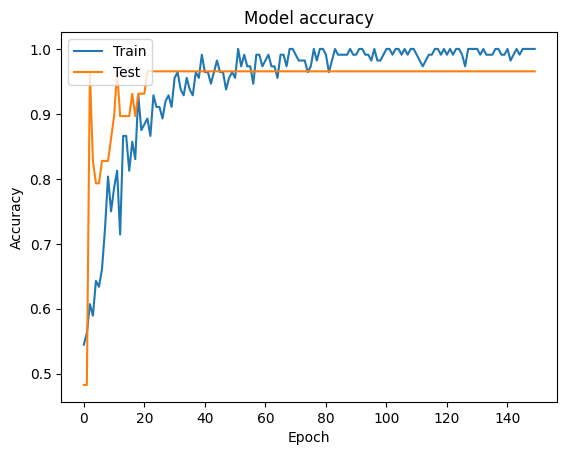

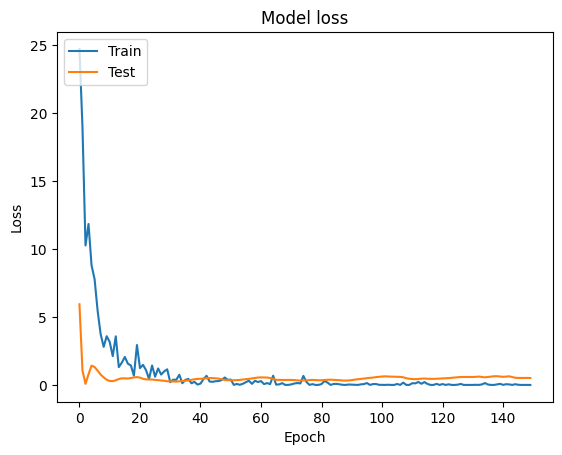

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9655 - loss: 0.5119
Test loss: 0.5119
Test accuracy: 0.9655


In [7]:
# Training the model
def train_model(X_train, y_train, X_test, y_test, epochs=150, batch_size=32):
    input_shape = X_train.shape[1]
    model = create_model(input_shape)

    # Callbacks for early stopping and model checkpoint
    # early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test))
    # history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
    #                     validation_data=(X_test, y_test), callbacks=[early_stopping])
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    return model, history
X_train, X_test, y_train, y_test, label_encoder = load_and_preprocess_data(scream_folder, non_scream_folder)
model, history = train_model(X_train, y_train, X_test, y_test)
evaluate_model(model, X_test, y_test)


In [8]:
# Function to predict whether an audio file contains a scream or not
def predict_audio(file_path, model, label_encoder):
    
    feature = extract_features(file_path)
    feature = np.array(feature).reshape(1, -1)
    prediction = model.predict(feature)
    display(Audio(file_path))

    if len(prediction) == 0:
        return "Unknown"

    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]

In [9]:
# Example to test an audio file

# Test : 1

audio_file_to_test = "Assets/testing/n1.wav"
predicted_label = predict_audio(audio_file_to_test, model, label_encoder)
print(f"The predicted label for {audio_file_to_test} is: {predicted_label}")
print()

if predicted_label == 1:
  print("Nearby Officer is alerted")
else:
  print("No alert required")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


The predicted label for Assets/testing/n1.wav is: 0

No alert required


In [10]:
# Example to test an audio file

# Test : 2

audio_file_to_test = "Assets/testing/p1.wav"
predicted_label = predict_audio(audio_file_to_test, model, label_encoder)
print(f"The predicted label for {audio_file_to_test} is: {predicted_label}")
print()

if predicted_label == 1:
  print("Nearby Officer is alerted")
else:
  print("No alert required")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


The predicted label for Assets/testing/p1.wav is: 1

Nearby Officer is alerted


In [11]:
# Function to record audio and save it to testing
def record_audio(output_file, duration=10, sample_rate=44100):
    print(f"Recording... Please speak for {duration} seconds.")

    # Record audio
    audio_data = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype=np.int16)
    sd.wait()

    # Save the recorded audio to a file
    write(output_file, sample_rate, audio_data)

    print(f"Recording saved to {output_file}.")

In [12]:
# Example to record audio and test the prediction
output_file_path = "Assets/testing/recorded_audio.wav"
record_audio(output_file_path)

# Predict the label for the recorded audio
predicted_label = predict_audio(output_file_path, model, label_encoder)
print(f"The predicted label for the recorded audio is: {predicted_label}")
print()

if predicted_label == 1:
    print("Nearby Officer is alerted")
else:
    print("No alert required")

Recording... Please speak for 10 seconds.
Recording saved to Assets/testing/recorded_audio.wav.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


The predicted label for the recorded audio is: 0

No alert required
